In [1]:
import os
from concurrent.futures import ProcessPoolExecutor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from uf3.data import io
from uf3.data import geometry
from uf3.data import composition
from uf3.representation import bspline
from uf3.representation import process
from uf3.regression import least_squares
from uf3.forcefield import calculator
from uf3.forcefield import lammps
from uf3.util import parallel
from uf3.util import plotting

from uf3.util import plotting3d

# $\text{UF}_{2,3}$ Demo: Elemental tungsten

**Data split**
- Training set: 1939 configurations (stratified 20% of the dataset)

- Holdout: 7754 configurations (remaining 80%)

**Inputs**
- ```w-14.xyz``` (30 mb)
- ```training_idx.txt``` (10 kb, included for reproducibility purposes)

**Outputs**
- ```df_features_uf23.h5``` (650 mb)
- ```model_uf23.json``` (3 kb)

In [4]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

 Step         | Estimated Time 
:-------------|:--------------
Preprocessing | 10 seconds
Featurization | 20 core-minutes (parallelizable)
Training      | 4 seconds
Prediction    | 3 seconds
Plotting      | 10 seconds

# User Parameters

```element_list (list)```: list of element symbols

```degree (int)```: truncation of many-body expansion. A value of 3 yields a two-and-three-body potential.

In [5]:
element_list = ['W']
degree = 3

Initialize the ```ChemicalSystem``` and inspect interactions.

Elements involved in each interactions are sorted by electronegativity.

In [6]:
chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)
print(chemical_system)

ChemicalSystem:
    Elements: ('W',)
    Degree: 3
    Pairs: [('W', 'W')]
    Trios: [('W', 'W', 'W')]


In [7]:
print("Trios:", chemical_system.interactions_map[3])

Trios: [('W', 'W', 'W')]


# Selecting cutoffs

```r_min_map (dict)```: map of minimum pair distance per interaction (angstroms). 
    If unspecified, defaults to 1.0 for all interactions.
    
```r_max_map (dict)```: map of maximum pair distance per interaction (angstroms). 
    If unspecified, defaults to 6.0 angstroms for all interactions, which probably encompasses at least 2nd-nearest neighbors.
    
```resolution_map (dict)```: map of resolution (number of knot intervals) per interaction. 
    For the cubic basis, the number of basis functions equals three more than the number of knot intervals.
    This is, in turn, negated by ```trailing_trim```.
    If unspecified, defaults to 20 for all two-body interactions and 5 for three-body interactions.
    
```trailing_trim (int)```: number of trailing basis functions to trim, defaults to 3.
 - ```= 0```: hard cutoff at ```r_max```
 - ```= 1```: function goes to zero at ```r_max```
 - ```= 2```: first derivative goes to zero at ```r_max```
 - ```= 3```: second derivative goes to zero at ```r_max```
 
```leading_trim (int)```: similar for leading basis functions (small distances), defaults to 0 for 2-body and 3 for 3-body

**Note: the demo's resolution and cutoffs (3.5-3.5-7.0Å, 6-6-12) are small to reduce runtime and filesize.**

**Results in the manuscript use (4.25-4.25-8.5Å, 10-10-20), requiring about 20 core-minutes and 6 gb.**

## Sensible values can be chosen based on the results from the two-body demo.
**r_min and r_max should span the region near the two-body potential minimum
and any inflection points.**

**High values for r_max increase the size of neighbor lists and slows down calculations.
Sensible values for r_max for the two-body terms can be quickly estimated
through grid-search in the two-body demo.**

**r_max for the three-body can be slightly lower based on the assumption that
higher-order terms are most important for nearest neighbors.**

In [8]:
r_min_map = {("W", "W"): 0.001,
             ("W", "W", "W"): [1.5, 1.5, 1.5],
            }
r_max_map = {("W", "W"): 5.5,
             ("W", "W", "W"): [3.5, 3.5, 7.0],
            }
resolution_map = {("W", "W"): 15,
                  ("W", "W", "W"): [6, 6, 12],
                 }
trailing_trim = {2: 3, 3: 3}  # 3 for 2-body, 3 for 3-body
leading_trim = {2: 0, 3: 3}  # 0 for 2-body, 3 for 3-body
# Integer values are also accepted for the trim parameters, in which case the
# same value is used for both 2-body and 3-body.

# Demo parameters
```n_cores```: number of workers to use in parallel for feature generation

```data_filename```: filename of reference data including geometries, energies, forces, ...

```training_1939```: list of integers corresponding to entries to use for training.

```filename```: filename to save features dataframe.

```table_template```: format string for table names in feature dataframe.

In [11]:
n_cores = 4

In [12]:
example_directory = os.getcwd()
data_filename = os.path.join(example_directory, "w-14.xyz")
with open(os.path.join(example_directory, "training_idx.txt"), "r") as f:
    training_1939 = [int(idx) for idx in f.read().splitlines()]

In [13]:
filename = "df_features.h5"
table_template = "features_{}"

# Initialize basis

In [14]:
bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      leading_trim=leading_trim,
                                      trailing_trim=trailing_trim)

```bspline_config.get_interaction_partitions()``` yields the number of coefficients for each n-body interaction (one-body terms, two-body terms, three-body terms, ...) as well as the starting index in the coefficient vector for each interaction.

In [15]:
bspline_config.get_interaction_partitions()[0]

{'W': 1, ('W', 'W'): 18, ('W', 'W', 'W'): 54}

In [16]:
bspline_config.get_interaction_partitions()[1]

{'W': 0, ('W', 'W'): 1, ('W', 'W', 'W'): 19}

# Load data

In [17]:
data_coordinator = io.DataCoordinator()
data_coordinator.dataframe_from_trajectory(data_filename,
                                           prefix='dft')
df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 9693
Number of forces: 475578


In [18]:
df_data.head()

,geometry,energy,fx,fy,fz,size
dft_0,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.194835,[0.0],[0.0],[0.0],1.0
dft_1,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.126991,[0.0],[0.0],[0.0],1.0
dft_2,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.133282,[0.0],[0.0],[0.0],1.0
dft_3,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.139626,[0.0],[0.0],[0.0],1.0
dft_4,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.142003,[0.0],[0.0],[0.0],1.0


# Examine pair distance distribution
Useful step that serves as a sanity check for selected cutoffs and resolution.

In [19]:
from uf3.data import analyze
from tqdm.auto import tqdm

In [20]:
analyzer = analyze.DataAnalyzer(chemical_system, 
                                r_cut=10.0,
                                bins=0.01)

In [21]:
atoms_key = data_coordinator.atoms_key
histogram_slice = np.random.choice(np.arange(len(df_data)),
                                   min(1000, len(df_data)),
                                   replace=False)
df_slice = df_data[atoms_key].iloc[histogram_slice]
analyzer.load_entries(df_slice)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
analysis = analyzer.analyze()

    Smallest observed: 1.99 angstroms
    Suggested Cutoffs: [3.16  3.21  3.43  3.66  3.72  3.76  3.8   3.865 4.175 4.47  4.52  4.885
 5.25  5.3   5.38  5.47  5.53  5.565 5.67  5.815 5.885 5.95  6.155 6.34
 6.39  6.425 6.685 6.96  7.025 7.085 7.135 7.295 7.445 7.605 7.765 7.815
 8.03  8.235 8.285 8.63  8.97  9.02  9.06  9.215 9.38  9.43  9.475 9.51
 9.56  9.695 9.805]


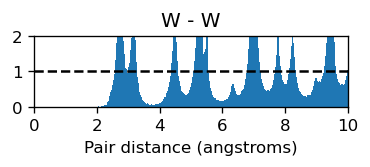

In [23]:
canvases = plotting.plot_pair_distributions(analysis, show_cutoffs=False, figsize=(3.5, 1.5))
for fig, ax in canvases:
    fig.set_dpi(120)
    fig.tight_layout()
    ax.set_ylabel("")
    # fig.show()

# Compute energy and force features



In [24]:
representation = process.BasisFeaturizer(bspline_config)

In [25]:
client = ProcessPoolExecutor(max_workers=n_cores)

In [26]:
representation.batched_to_hdf(filename,
                              df_data,
                              client,
                              n_jobs = n_cores,
                              batch_size=50,
                              progress="bar",
                              table_template=table_template)

  0%|          | 0/194 [00:00<?, ?it/s]

# Fit model

In [27]:
regularizer = bspline_config.get_regularization_matrix(ridge_1b=0.0,
                                                       ridge_2b=0.0,
                                                       ridge_3b=1e-8,
                                                       curvature_2b=1e-8,
                                                       curvature_3b=0.0)

model = least_squares.WeightedLinearModel(bspline_config,
                                          regularizer=regularizer)

# Fit with energies and force

Train with 20% of the dataset (1939 samples)

In [28]:
model.fit_from_file(filename, 
                    df_data.index[training_1939],
                    weight=0.8, 
                    batch_size=2500,
                    energy_key="energy", 
                    progress="bar")

  0%|          | 0/194 [00:00<?, ?it/s]

('W', 'W') Correction: adjusted 5 coefficients.


(-0.5, 0.5)

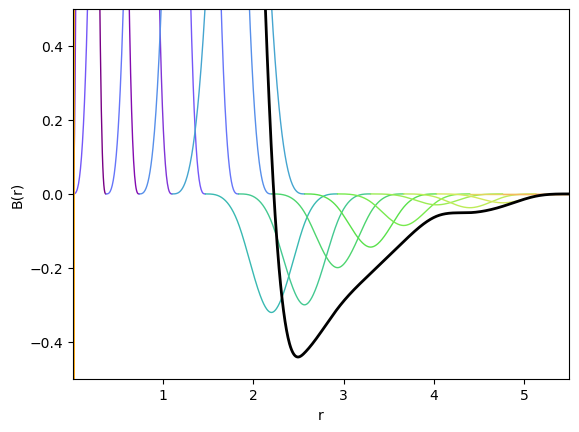

In [29]:
pair = ("W", "W")

r_target = analysis["lower_bounds"][pair]
model.fix_repulsion_2b(pair, 
                       r_target=r_target,
                       min_curvature=0.0)

solutions = least_squares.arrange_coefficients(model.coefficients,
                                               bspline_config)
coefficients = solutions[("W", "W")]
knot_sequence = bspline_config.knots_map[("W", "W")]
fig, ax = plotting.visualize_splines(coefficients, knot_sequence)
plt.vlines([0.0], -100, 100, color="orange", linewidth=2)
ax.set_ylim(-0.5, 0.5)

In [36]:
tbp = plotting3d.ThreeBodyPlotter(model, ("W", "W", "W"))
tbp.sample_uniformly(20)
tbp.plot_uniform(val_limit=0.1)

1.5 7.0


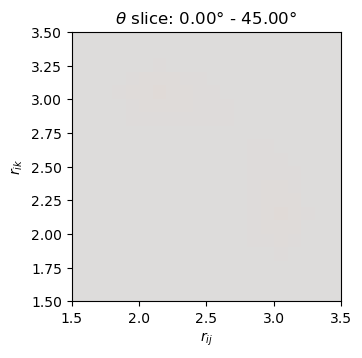

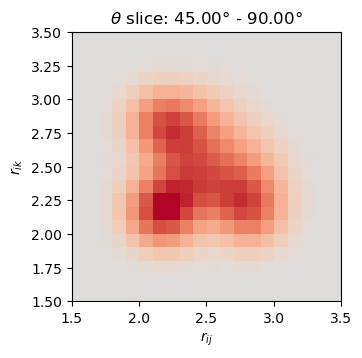

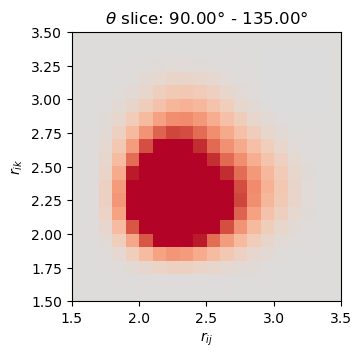

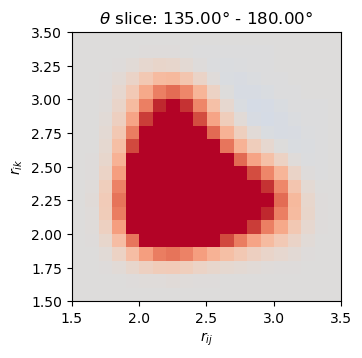

In [37]:
slices = tbp.plot_slices(n_slices=4)

# Prediction

In [38]:
# predict with remaining 80% of dataset
training_keys = df_data.index[training_1939]
holdout_keys = df_data.index.difference(training_keys)

In [39]:
y_e, p_e, y_f, p_f, rmse_e, rmse_f = model.batched_predict(filename, 
                                                           keys=holdout_keys)

RMSE (energy): 0.013
RMSE (forces): 0.198


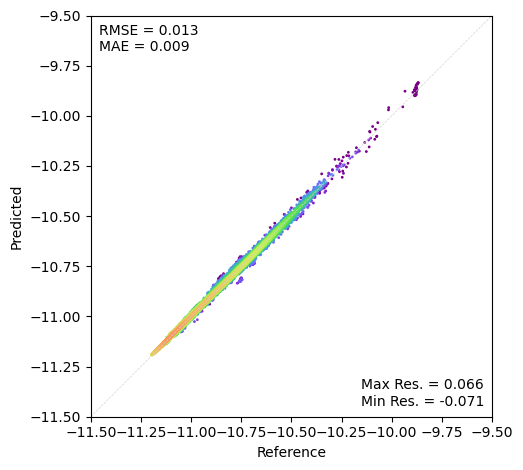

In [40]:
plotting.density_scatter(y_e, p_e)
plt.tight_layout()

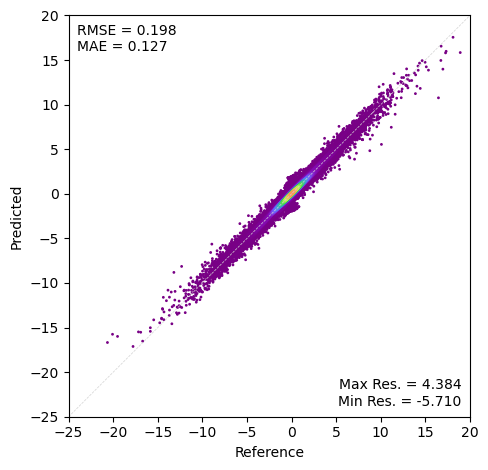

In [41]:
plotting.density_scatter(y_f, p_f)
plt.tight_layout()

# Export potential

In [42]:
model.to_json("model_2and3.json")

# Compute energy, forces, stress with UFCalculator

In [43]:
calc = calculator.UFCalculator(model)

geom = df_data.iloc[3000]['geometry'].copy()  # 12-atom cell
geom.set_calculator(calc)
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
print("Forces:\n", geom.get_forces())
print("Max force:", np.max(np.abs(geom.get_forces())))

Energy: -130.0631190040683
Stresses (numerical): [-0.08596182 -0.06690784 -0.05453652  0.00427117 -0.0131435  -0.02454886]
Forces:
 [[-0.45495605  5.67126882 -0.47125612]
 [-1.60261801 -0.31051681  0.56904939]
 [ 1.63235325  1.38841387  0.43666946]
 [ 1.58389908 -4.65034525  0.25918329]
 [-1.0572266  -2.45835978 -1.27937549]
 [-1.7110442   2.66451304  0.86440743]
 [-2.33848599 -1.8290439   0.79424123]
 [ 1.41630259  0.75658396 -0.89221646]
 [ 2.1608171  -0.207257   -0.20033168]
 [-0.03911018 -4.37703277  0.08769002]
 [-1.68278308  2.80469938  0.18286486]
 [ 2.09285208  0.54707643 -0.35092592]]
Max force: 5.671268821384928
